# Simple Univariate Linear Regression

Notebook by Anthony Rodriguez

In [1]:
import os, math
from pathlib import Path

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

# Introduction

This notebook displays exploratory data analysis (EDA) and linear regression on a [simple kaggle dataset for linear regression](https://www.kaggle.com/datasets/andonians/random-linear-regression) that needs no data cleaning. This data set is just going to be used to practice using basic EDA and linear regression with one variable.

# Helper functions for EDA

In [3]:
def fetch_file(file, data_dir="data"):
    """
    Fetch a file that was previously downloaded into the data folder. 
    
    file: the file in which to fetch
    data_dir: (default="data") the location to fetch the data
    
    return: The pathlib.Path object representing the file.
    """
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok = True)
    file_path = data_dir / Path(file)

    return file_path

In [4]:
def num_lines_in_file(file):
    """
    Gets the number of lines in a file.
    
    file: the file
    
    return: The number of lines in a file.
    """
    with open(file, 'r') as f:
        num_lines = sum(1 for l in f)
        
    return num_lines

In [5]:
def print_file_contents(file, num_lines=20):
    """
    Prints the file contents.
    
    file: The file.
    num_lines: (default=20) The number of lines in the file to print.
    """
    print(f'{file} ===========================')
    
    with open(file,'r') as f:
        for i in range(num_lines):
            print(f'{i}\t{repr(f.readline())}')

In [6]:
def print_dataframe_shape(df):
    """
    Prints the shape of the DataFrame.
    
    df: The DataFrame.
    """
    num_rows, num_cols = df.shape
    print(f'Number of rows in data frame: {num_rows}')
    print(f'Number of columns in data fram: {num_cols}')

# Exploratory Data Analysis (EDA)

#### The file is already downloaded. Let's fetch the downloaded file from the data directory.

In [7]:
training_set_filename = "train.csv"
test_set_filename = "test.csv"

In [8]:
training_set_file = fetch_file(training_set_filename)
training_set_file

WindowsPath('data/train.csv')

#### Let's look at the size of the file.

In [9]:
print(f'training_set_file is {os.path.getsize(training_set_file) / 1e6} MB')

training_set_file is 0.010384 MB


#### Let's look at the number of lines in the training set.

In [10]:
num_lines = num_lines_in_file(training_set_file)
print(f'The training set file has {num_lines} lines of data.')

The training set file has 701 lines of data.


#### Let's check the contents of the file to make sure it is a csv file.

In [11]:
print_file_contents(training_set_file)

data\train.csv ===========================
0	'x,y\n'
1	'24,21.54945196\n'
2	'50,47.46446305\n'
3	'15,17.21865634\n'
4	'38,36.58639803\n'
5	'87,87.28898389\n'
6	'36,32.46387493\n'
7	'12,10.78089683\n'
8	'81,80.7633986\n'
9	'25,24.61215147\n'
10	'5,6.963319071\n'
11	'16,11.23757338\n'
12	'16,13.53290206\n'
13	'24,24.60323899\n'
14	'39,39.40049976\n'
15	'54,48.43753838\n'
16	'60,61.69900319\n'
17	'26,26.92832418\n'
18	'73,70.4052055\n'
19	'29,29.34092408\n'


#### File looks like a standard csv file with two columns of real numbers. First line contains the column headings. 

#### Let's create a data frame

In [12]:
training = pd.read_csv(training_set_file)
training.head()

,x,y
0,24.0,21.549452
1,50.0,47.464463
2,15.0,17.218656
3,38.0,36.586398
4,87.0,87.288984


In [13]:
print_dataframe_shape(training)

Number of rows in data frame: 700
Number of columns in data fram: 2


#### The number of rows is 700 which is one less then what we seen before when checking the number of rows in the entire file. This is because the file contains a header row which states the names of each column (x and y).

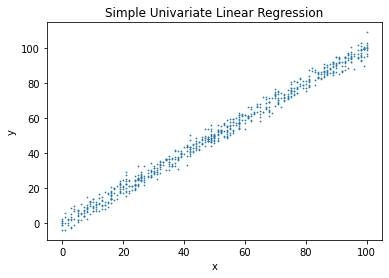

In [14]:
# Plot the data points.
plt.scatter(training['x'], training['y'], s=.5)
plt.title('Simple Univariate Linear Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Let's make sure all data is numeric.

In [15]:
training.dtypes

x    float64
y    float64
dtype: object

In [16]:
training['x'].isnull().values.any()

False

In [17]:
training['y'].isnull().values.any()

True

In [18]:
training['y'].isnull().sum()

1

#### There is a value in the y column that is NaN. Only one exists. I think we can just get rid of the sample that has a NaN for a y-value and our model will be fine. Let's find the index of this sample and then remove it from our data frame.

In [19]:
training[training['y'].isnull()]

,x,y
213,3530.157369,NaN


In [20]:
cleaned_training = training.drop(213)

In [21]:
cleaned_training['y'].isnull().values.any()

False

In [22]:
cleaned_training['x'].isnull().values.any()

False

In [23]:
print_dataframe_shape(cleaned_training)

Number of rows in data frame: 699
Number of columns in data fram: 2


# Training a Univariate Linear Regression Model

#### This data will allow us to use a linear function $f$ of one variable $x$. That is, $f_{w,b}(x) = wx + b$. 

$w$ and $b$ are parameters we must find.

#### We can do this by minimizing the cost $J(w,b) = \frac{1}{2m}\sum\limits^{m-1}_{i=0}(f_{w,b}(x^{(i)}) - y^{(i)})^{2}$
#### $f_{w,b}(x) = wx + b$ is the estimated cost.
#### $y^{(i)}$ is the true cost.

#### In order to find $w$ and $b$ by minimizing the cost $J(w,b)$, we must use it's gradient

$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \newline
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})
\end{align}
$$

#### We then repeat until convergence

$$\begin{align*} \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline
\end{align*}$$

#### where, parameters $w$, $b$ are updated simultaneously.  

In [24]:
def compute_loss(x, y, w, b, i):
    """
    Creates a linear model using parameters w and b to
    compute a predicted value with the ith training example
    and then computes the loss of the predicted value.
    
    x: The training example.
    y: The target/actual value.
    w: The weight of the feature/training example x.
    b: A model parameter.
    i: The index of the training example.
    
    returns: The loss/error of the model prediction of the ith training example.
    """
    f_xi = w * x[i] + b
    return f_xi - y[i]

In [25]:
def compute_mse(x, y, w, b):
    """
    Computes the mean-squared error of the model.
    
    x: The training example.
    y: The target/actual value.
    w: The weight of the feature/training example x.
    b: A model parameter.
    
    returns: The mean-squared error.
    """
    m = x.shape[0]
    i = 0
    total_loss = 0
    
    while i < m:
        loss_i = compute_loss(x, y, w, b, i)
        total_loss = total_loss + (loss_i**2)
        i += 1
    
    return total_loss / m
        

In [26]:
def compute_cost(x, y, w, b):
    """
    The model cost.
    
    x: The training examples.
    y: The target values.
    w: The weight of the features/training examples x.
    b: A model parameter.
    
    returns: The cost of the model.
    """
    return compute_mse(x, y, w, b) / 2

In [27]:
compute_mse(cleaned_training['x'].to_numpy(), cleaned_training['y'].to_numpy(), 1, 0)


7.873654280369422

In [28]:
def compute_gradient(x, y, w, b):
    """
    Computes the gradient for linear regression.
    
    x: The training examples.
    y: The target values.
    w: The weight of the features/training examples x.
    b: A model parameter.
    
    returns: The gradient w.r.t. w and the gradient w.r.t. b
    """
    m = x.shape[0]
    i = 0
    loss = 0
    dj_dw = 0
    dj_db = 0
    
    while i < m:
        loss = compute_loss(x, y, w, b, i)
        dj_dw_i = loss * x[i]
        dj_db_i = loss
        dj_dw += dj_dw_i
        dj_db += dj_db_i
        i += 1
        
    dj_dw, dj_db = dj_dw  / m, dj_db / m
    return dj_dw, dj_db

In [29]:
class Gradient_Descent:
    """
    A class for the gradient descent algorithm.
    """
    def __init__(self, cost_function, gradient_function, alpha, max_iters):
        """
        Creates an Gradient_Descent object.
        
        self: A Gradient_Descent object.
        cost_function: A function that computes the model cost.
        gradient_function: A function that computes the gradient.
        alpha: The learning rate.
        max_iters: The maximum number of iterations of the gradient descent algorithm.
        """
        self.cost_function = cost_function
        self.gradient_function = gradient_function
        self.alpha = alpha
        self.max_iters = max_iters
        
    def algorithm(self, x_train, y_train, w = 0, b = 0):
        '''
        Much of this gradient descent code is from Andrew Ng's Machine Learning course.
        
        The gradient descent algorithm.
        
        self: A Gradient_Descent object.
        x_train: The training examples.
        y_train: The targets.
        w: The parameter/weight of the training examples.
        b: A model parameter.
        '''
        # An array to store cost J and w's at each iteration primarily for graphing later
        J_history = []
        p_history = []
        
        for i in range(self.max_iters):
            # Calculate the gradient and update the parameters using gradient_function
            dj_dw, dj_db = self.gradient_function(x_train, y_train, w , b)
            
            # Record old parameters
            last_b, last_w = b, w

            # Update Parameters
            b = b - alpha * dj_db                            
            w = w - alpha * dj_dw
            
            # Check if new parameters are equal to the last iterations parameters
            if self.are_equal(b, last_b) and self.are_equal(w, last_w):
                print('Convergence')
                print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                      f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                      f"w: {w: 0.3e}, b:{b: 0.5e}")
                break
                
            # Save cost J at each iteration
            if i<100000:      # prevent resource exhaustion 
                J_history.append(self.cost_function(x_train, y_train, w , b))
                p_history.append([w,b])
            # Print cost every at intervals 10 times or as many iterations if < 10
            if i% math.ceil(self.max_iters/10) == 0:
                print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                      f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                      f"w: {w: 0.3e}, b:{b: 0.5e}")

        return w, b, J_history, p_history #return w and J,w history for graphing
    
    def are_equal(self, old_val, new_val, epsilon = 1.0e-6):
        return abs(old_val - new_val) < epsilon

#### Let's test the implementation with two training points.

In [30]:
x_train = np.array([1.0, 2.0])   #features
y_train = np.array([300.0, 500.0])   #target value

#### Let's plot the two points.

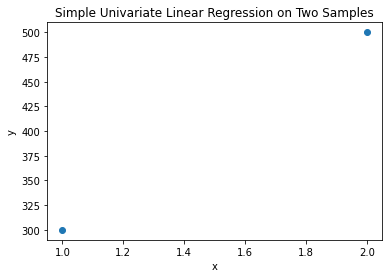

In [31]:
# Plot the data points.
plt.scatter(x_train, y_train)
plt.title('Simple Univariate Linear Regression on Two Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Let's run gradient descent to find the model parameters.

In [32]:
# Gradient descent settings
iterations = 10000
alpha = 1.0e-2
gradient_descent = Gradient_Descent(compute_cost, compute_gradient, alpha, iterations)
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent.algorithm(x_train, y_train)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 7.93e+04  dj_dw: -6.500e+02, dj_db: -4.000e+02   w:  6.500e+00, b: 4.00000e+00
Iteration 1000: Cost 3.41e+00  dj_dw: -3.712e-01, dj_db:  6.007e-01   w:  1.949e+02, b: 1.08228e+02
Iteration 2000: Cost 7.93e-01  dj_dw: -1.789e-01, dj_db:  2.895e-01   w:  1.975e+02, b: 1.03966e+02
Iteration 3000: Cost 1.84e-01  dj_dw: -8.625e-02, dj_db:  1.396e-01   w:  1.988e+02, b: 1.01912e+02
Iteration 4000: Cost 4.28e-02  dj_dw: -4.158e-02, dj_db:  6.727e-02   w:  1.994e+02, b: 1.00922e+02
Iteration 5000: Cost 9.95e-03  dj_dw: -2.004e-02, dj_db:  3.243e-02   w:  1.997e+02, b: 1.00444e+02
Iteration 6000: Cost 2.31e-03  dj_dw: -9.660e-03, dj_db:  1.563e-02   w:  1.999e+02, b: 1.00214e+02
Iteration 7000: Cost 5.37e-04  dj_dw: -4.657e-03, dj_db:  7.535e-03   w:  1.999e+02, b: 1.00103e+02
Iteration 8000: Cost 1.25e-04  dj_dw: -2.245e-03, dj_db:  3.632e-03   w:  2.000e+02, b: 1.00050e+02
Iteration 9000: Cost 2.90e-05  dj_dw: -1.082e-03, dj_db:  1.751e-03   w:  2.000e+02, b: 1.00024e+02


#### Let's plot the model againts the two points.

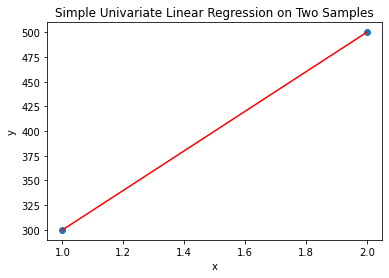

In [33]:
w = 199.9929
b = 100.0116
x = np.linspace(1, 2, 100)
f_x = w * x + b
plt.plot(x, f_x, color='red')
plt.scatter(x_train, y_train)
plt.title('Simple Univariate Linear Regression on Two Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### The model looks good!
#### Now let's run gradient descent on our initial training set using 100000 iterations and different alphas.

In [34]:
# Gradient descent settings
iterations = 100000
alpha = 1.0e-4
gradient_descent = Gradient_Descent(compute_cost, compute_gradient, alpha, iterations)
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent.algorithm(cleaned_training['x'].to_numpy(), cleaned_training['y'].to_numpy(), 1, 0)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 3.94e+00  dj_dw:  3.173e+00, dj_db:  7.444e-02   w:  9.997e-01, b:-7.44370e-06
Iteration 10000: Cost 3.93e+00  dj_dw: -3.135e-04, dj_db:  2.093e-02   w:  9.994e-01, b:-2.37987e-02
Iteration 20000: Cost 3.93e+00  dj_dw: -2.440e-04, dj_db:  1.629e-02   w:  9.997e-01, b:-4.23071e-02
Iteration 30000: Cost 3.93e+00  dj_dw: -1.899e-04, dj_db:  1.267e-02   w:  9.999e-01, b:-5.67113e-02
Convergence
Iteration 39453: Cost 3.93e+00  dj_dw: -1.498e-04, dj_db:  1.000e-02   w:  1.000e+00, b:-6.73782e-02
(w,b) found by gradient descent: (  1.0001, -0.0674)


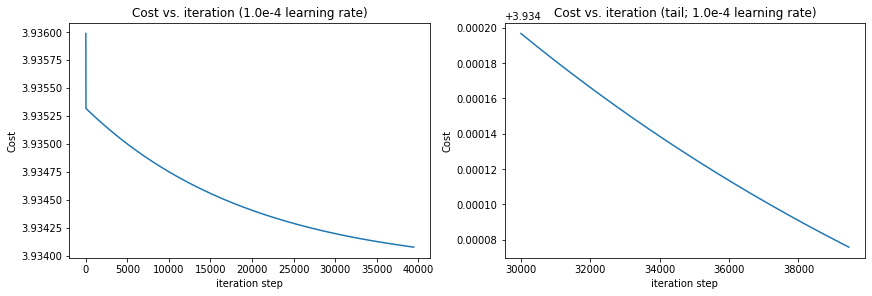

In [35]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(30000 + np.arange(len(J_hist[30000:])), J_hist[30000:])
ax1.set_title("Cost vs. iteration (1.0e-4 learning rate)");  ax2.set_title("Cost vs. iteration (tail; 1.0e-4 learning rate)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

In [36]:
# Gradient descent settings
iterations = 100000
alpha = 1.0e-5
gradient_descent = Gradient_Descent(compute_cost, compute_gradient, alpha, iterations)
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent.algorithm(cleaned_training['x'].to_numpy(), cleaned_training['y'].to_numpy(), 0, 55)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 4.33e+02  dj_dw: -5.846e+02, dj_db:  5.060e+00   w:  5.846e-03, b: 5.49999e+01
Iteration 10000: Cost 3.66e+02  dj_dw: -2.019e-01, dj_db:  1.347e+01   w:  1.955e-01, b: 5.36381e+01
Iteration 20000: Cost 3.48e+02  dj_dw: -1.969e-01, dj_db:  1.314e+01   w:  2.154e-01, b: 5.23074e+01
Iteration 30000: Cost 3.32e+02  dj_dw: -1.920e-01, dj_db:  1.281e+01   w:  2.348e-01, b: 5.10097e+01
Iteration 40000: Cost 3.16e+02  dj_dw: -1.872e-01, dj_db:  1.250e+01   w:  2.538e-01, b: 4.97442e+01
Iteration 50000: Cost 3.00e+02  dj_dw: -1.826e-01, dj_db:  1.219e+01   w:  2.723e-01, b: 4.85099e+01
Iteration 60000: Cost 2.86e+02  dj_dw: -1.781e-01, dj_db:  1.189e+01   w:  2.903e-01, b: 4.73063e+01
Iteration 70000: Cost 2.72e+02  dj_dw: -1.737e-01, dj_db:  1.159e+01   w:  3.079e-01, b: 4.61324e+01
Iteration 80000: Cost 2.59e+02  dj_dw: -1.694e-01, dj_db:  1.131e+01   w:  3.251e-01, b: 4.49876e+01
Iteration 90000: Cost 2.46e+02  dj_dw: -1.652e-01, dj_db:  1.103e+01   w:  3.418e-01, b: 4.3

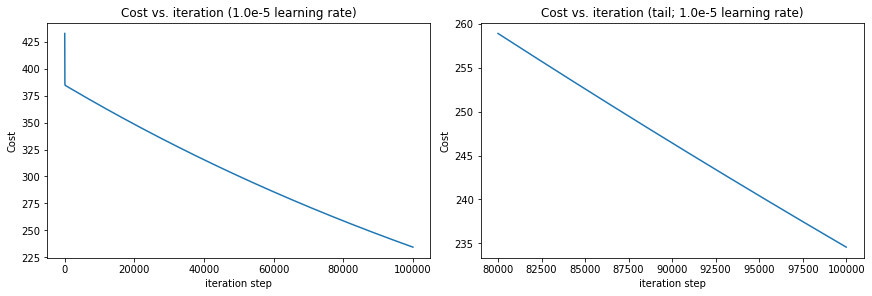

In [37]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(80000 + np.arange(len(J_hist[80000:])), J_hist[80000:])
ax1.set_title("Cost vs. iteration (1.0e-5 learning rate)");  ax2.set_title("Cost vs. iteration (tail; 1.0e-5 learning rate)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

In [38]:
# Gradient descent settings
iterations = 100000
alpha = 1.0e-6
gradient_descent = Gradient_Descent(compute_cost, compute_gradient, alpha, iterations)
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent.algorithm(cleaned_training['x'].to_numpy(), cleaned_training['y'].to_numpy(), 0, 55)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 4.36e+02  dj_dw: -5.846e+02, dj_db:  5.060e+00   w:  5.846e-04, b: 5.50000e+01
Iteration 10000: Cost 3.83e+02  dj_dw: -2.065e-01, dj_db:  1.378e+01   w:  1.771e-01, b: 5.48646e+01
Iteration 20000: Cost 3.81e+02  dj_dw: -2.060e-01, dj_db:  1.375e+01   w:  1.791e-01, b: 5.47270e+01
Iteration 30000: Cost 3.79e+02  dj_dw: -2.054e-01, dj_db:  1.371e+01   w:  1.812e-01, b: 5.45897e+01
Iteration 40000: Cost 3.77e+02  dj_dw: -2.049e-01, dj_db:  1.368e+01   w:  1.833e-01, b: 5.44527e+01
Iteration 50000: Cost 3.75e+02  dj_dw: -2.044e-01, dj_db:  1.364e+01   w:  1.853e-01, b: 5.43161e+01
Iteration 60000: Cost 3.73e+02  dj_dw: -2.039e-01, dj_db:  1.361e+01   w:  1.873e-01, b: 5.41799e+01
Iteration 70000: Cost 3.72e+02  dj_dw: -2.034e-01, dj_db:  1.358e+01   w:  1.894e-01, b: 5.40439e+01
Iteration 80000: Cost 3.70e+02  dj_dw: -2.029e-01, dj_db:  1.354e+01   w:  1.914e-01, b: 5.39083e+01
Iteration 90000: Cost 3.68e+02  dj_dw: -2.024e-01, dj_db:  1.351e+01   w:  1.934e-01, b: 5.3

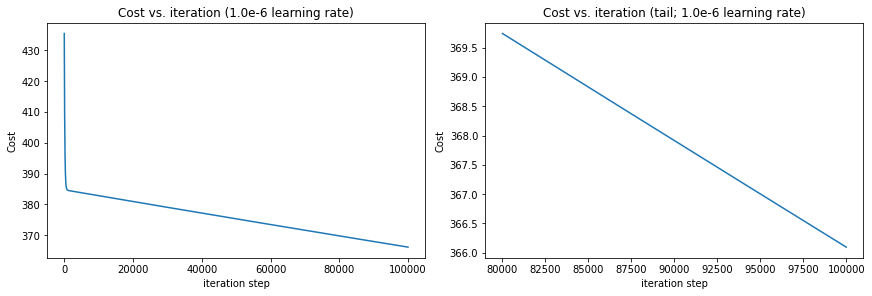

In [39]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(80000 + np.arange(len(J_hist[80000:])), J_hist[80000:])
ax1.set_title("Cost vs. iteration (1.0e-6 learning rate)");  ax2.set_title("Cost vs. iteration (tail; 1.0e-6 learning rate)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

In [40]:
# Gradient descent settings
iterations = 100000
alpha = 1.0e-7
gradient_descent = Gradient_Descent(compute_cost, compute_gradient, alpha, iterations)
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent.algorithm(cleaned_training['x'].to_numpy(), cleaned_training['y'].to_numpy(), 0, 55)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 4.36e+02  dj_dw: -5.846e+02, dj_db:  5.060e+00   w:  5.846e-05, b: 5.50000e+01
Iteration 10000: Cost 3.85e+02  dj_dw: -2.092e+01, dj_db:  1.350e+01   w:  1.690e-01, b: 5.49887e+01
Iteration 20000: Cost 3.84e+02  dj_dw: -9.409e-01, dj_db:  1.380e+01   w:  1.752e-01, b: 5.49750e+01
Iteration 30000: Cost 3.84e+02  dj_dw: -2.328e-01, dj_db:  1.381e+01   w:  1.756e-01, b: 5.49612e+01
Iteration 40000: Cost 3.84e+02  dj_dw: -2.077e-01, dj_db:  1.380e+01   w:  1.758e-01, b: 5.49474e+01
Iteration 50000: Cost 3.84e+02  dj_dw: -2.068e-01, dj_db:  1.380e+01   w:  1.760e-01, b: 5.49336e+01
Iteration 60000: Cost 3.84e+02  dj_dw: -2.067e-01, dj_db:  1.380e+01   w:  1.763e-01, b: 5.49198e+01
Iteration 70000: Cost 3.83e+02  dj_dw: -2.066e-01, dj_db:  1.379e+01   w:  1.765e-01, b: 5.49060e+01
Iteration 80000: Cost 3.83e+02  dj_dw: -2.066e-01, dj_db:  1.379e+01   w:  1.767e-01, b: 5.48922e+01
Iteration 90000: Cost 3.83e+02  dj_dw: -2.065e-01, dj_db:  1.378e+01   w:  1.769e-01, b: 5.4

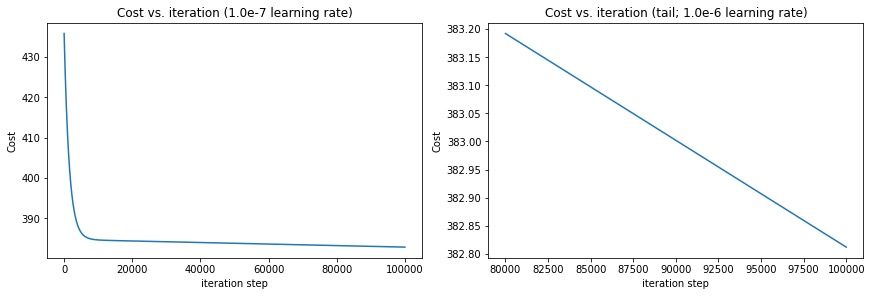

In [41]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(80000 + np.arange(len(J_hist[80000:])), J_hist[80000:])
ax1.set_title("Cost vs. iteration (1.0e-7 learning rate)");  ax2.set_title("Cost vs. iteration (tail; 1.0e-6 learning rate)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

#### Using an alpha of 1.0e-4 has the lowest cost. Let's plot the model with the found parameters of w = 1.0001 and b = -0.0674 .

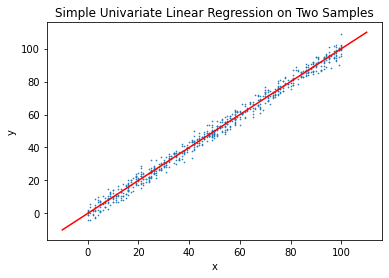

In [42]:
w = 1.0001
b = -0.0674
x = np.linspace(-10, 110, 1000)
f_x = w * x + b
plt.plot(x, f_x, color='red')
plt.scatter(cleaned_training['x'], cleaned_training['y'], s=.4)
plt.title('Simple Univariate Linear Regression on Two Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### The model looks like a great fit to the training data! Let's now make predictions for our test data.

In [43]:
test_set_file = fetch_file(test_set_filename)
test_set_file

WindowsPath('data/test.csv')

In [44]:
test = pd.read_csv(test_set_file)
test.head()

,x,y
0,77,79.775152
1,21,23.177279
2,22,25.609262
3,20,17.857388
4,36,41.849864


#### Let's see if the test data is clean.

In [52]:
test['x'].isnull().sum(), test['y'].isnull().sum()

(0, 0)

#### Let's predict using our model on the test set.

In [49]:
m = test.shape[0]
i = 0
f_test = w * test['x'] + b

while i < m:
    print(f'Prediction: {f_test[i]:.{4}f}\tTarget: {test["y"][i]}')
    i += 1

Prediction: 76.9403	Target: 79.77515201
Prediction: 20.9347	Target: 23.17727887
Prediction: 21.9348	Target: 25.60926156
Prediction: 19.9346	Target: 17.85738813
Prediction: 35.9362	Target: 41.84986439
Prediction: 14.9341	Target: 9.805234876
Prediction: 61.9388	Target: 58.87465933
Prediction: 94.9421	Target: 97.61793701
Prediction: 19.9346	Target: 18.39512747
Prediction: 4.9331	Target: 8.746747654
Prediction: 3.9330	Target: 2.811415826
Prediction: 18.9345	Target: 17.09537241
Prediction: 95.9422	Target: 95.14907176
Prediction: 61.9388	Target: 61.38800663
Prediction: 35.9362	Target: 40.24701716
Prediction: 14.9341	Target: 14.82248589
Prediction: 64.9391	Target: 66.95806869
Prediction: 13.9340	Target: 16.63507984
Prediction: 86.9413	Target: 90.65513736
Prediction: 68.9395	Target: 77.22982636
Prediction: 88.9415	Target: 92.11906278
Prediction: 50.9377	Target: 46.91387709
Prediction: 88.9415	Target: 89.82634442
Prediction: 26.9353	Target: 21.71380347
Prediction: 96.9423	Target: 97.41206981
Pr

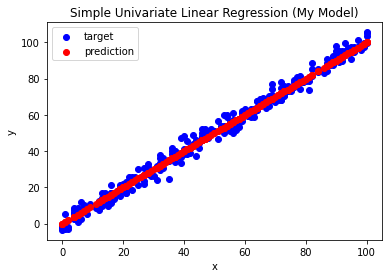

In [118]:
plt.scatter(test['x'], test['y'], color='blue', label='target')
plt.scatter(test['x'], f_test, color='red', label='prediction')
plt.legend(loc="upper left")
plt.title('Simple Univariate Linear Regression (My Model)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Let's use scikit-learn to compare our model

In [117]:
cleaned_train_x_arr = cleaned_training['x'].to_numpy().reshape(-1,1)
cleaned_train_y_arr = cleaned_training['y'].to_numpy()

In [110]:
reg = LinearRegression().fit(cleaned_train_x_arr, cleaned_train_y_arr)

In [116]:
b_reg = reg.intercept_
w_reg = reg.coef_
print(f"model parameters:                   w: {w_reg}, b:{b_reg}")
print(f"My model parameters: w: {w}, b: {b}")

model parameters:                   w: [1.00065638], b:-0.10726546430095141
My model parameters: w: 1.0001, b: -0.0674


In [113]:
reg.intercept_,reg.coef_

(-0.10726546430095141, array([1.00065638]))

In [124]:
reg_predict = reg.predict(test['y'].to_numpy().reshape(-1,1))
reg_predict

array([ 79.72024951,  23.08522655,  25.51880555,  17.76184393,
        41.77006842,   9.70440539,  58.80603812,  97.57474619,
        18.29993623,   8.6452234 ,   2.70599572,  16.99932804,
        95.10426042,  61.32103514,  40.16616911,  14.72494964,
        66.89475329,  16.53873334,  90.60737628,  77.17325315,
        92.0722626 ,  46.83740504,  89.77803934,  21.62079055,
        97.36874386,  56.94647264,  78.25470159,  19.03680181,
        92.98863479,  26.50131243,  97.50831905,  31.34861628,
        35.04303919,  78.55475731,  32.98557007,  51.62634098,
        53.55028352,  69.40138955,  27.33570816,  36.26303357,
        95.0165397 ,  68.10472585,  50.8877401 ,  77.98633467,
         5.50408017,  36.02978647,  67.17208201,  64.9486484 ,
        38.0653126 ,  34.22667039,  95.24031728,  87.79789516,
        54.00993914,  31.84432838,  59.54433393,  -1.14806239,
        47.41765622,  62.53472236,  70.85392502,  56.07793042,
        13.95768923,  68.05111458,  75.5393685 ,  59.15

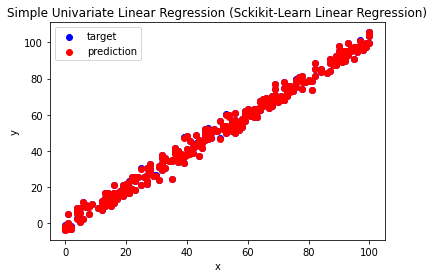

In [125]:
plt.scatter(test['x'], test['y'], color='blue', label='target')
plt.scatter(test['x'], reg_predict, color='red', label='prediction')
plt.legend(loc="upper left")
plt.title('Simple Univariate Linear Regression (Sckikit-Learn Linear Regression)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()